In [1]:
%matplotlib inline
#!/usr/bin/env python
# coding: utf-8

'''
sample command: python try_JointConcatPathway.py -c 0 --var 0 -k 0 -r 1 --data_dir ../data --spv 1
Individual training for BioTac data (full/partial data)
if -r=1, train with full data
if -r=2, train with half data
loss = classification loss + recon loss 
'''

# Import
import os,sys
import pickle
import argparse
from datetime import datetime
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from vrae.ConcatPathway import *
from utils import *
from preprocess_data import*

import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix
from gradflow_check import *
import copy

In /home/ruihan/anaconda3/envs/AE/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ruihan/anaconda3/envs/AE/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ruihan/anaconda3/envs/AE/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/ruihan/anaconda3/envs/AE/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ruihan/anaconda3/en

In [2]:
logDir = 'models_and_stats/'

### plot three models (fresh, loadFromBT20, loadFromBT30), for different data_folders

In [3]:
kfold_number = 0
column_names = ["model", "rep", "Fraction of the full dataset (%)", "Accuracy"]
tot_num = 1000

In [4]:
data_folders = ["c20icub_n200/", "c20icub_n400/", "c20icub_n600/", "c20icub_n800/", "c20icub/"]
num_sample_dict = {"c20icub_n200/": 200/tot_num*100, "c20icub_n400/": 400/tot_num*100, "c20icub_n600/": 600/tot_num*100, "c20icub_n800/": 800/tot_num*100, "c20icub/": 1000/tot_num*100}

In [5]:
# num_samples = [200, 400, 600, 800, 1000]
# transfer_acc = [0.65, 0.7625, 0.9, 0.90625, 0.91]
# fresh_acc = [0.575, 0.7375, 0.825, 0.9, 0.9]

In [6]:
all_df = pd.DataFrame(columns=column_names)

In [7]:
model_name_list = ["_ConcatPathway_ll40_ihs[100, 200]_ohs90_rf[20, 10]_res1.0_recGRU_midLSTMo3_ep100_lr0.0005_wc1_wr10.001_wr20.001_wkl0.0005_var1", "_ConcatPathway_loadFromBTc20", "_ConcatPathway_loadFromBTc30", "_ConcatPathway_loadFromBTc50"]
model_name_short_list = ["Baseline", "TL-BTc20", "TL-BTc30", "TL-BTc50"]

In [8]:
num_rep = 5
for data_folder in data_folders:
    for j in range(len(model_name_list)):
        df = pd.DataFrame(columns=column_names)
        for i in range(num_rep):
            try:
                stats_dict_dir = logDir + "icub_"+data_folder[:-1]+ model_name_list[j] + "_rep{}_fold{}_{}.pkl".format(i+1, kfold_number, i+1)
                stats_dict = pickle.load(open(stats_dict_dir, "rb"))
            except:
                try:
                    stats_dict_dir = logDir + "icub_"+data_folder[:-1]+ model_name_list[j] + "_fold{}_{}.pkl".format(kfold_number, i+1)
                    stats_dict = pickle.load(open(stats_dict_dir, "rb"))
                except:
                    raise ValueError("loading dict failed")
            
            df = df.append({"model": model_name_short_list[j], "rep": i+1, "Fraction of the full dataset (%)": num_sample_dict[data_folder], "Accuracy": stats_dict["test_acc"]}, ignore_index=True)
        print("df for {} shape: {}, acc: {}, data_folder: {}".format(model_name_list[j], df.shape, stats_dict["test_acc"], num_sample_dict[data_folder]))
        if all_df.shape[0] == 0:
            all_df = df
        else:
            all_df = all_df.append(df, ignore_index=True)
        print("all_df", all_df.shape)

df for _ConcatPathway_ll40_ihs[100, 200]_ohs90_rf[20, 10]_res1.0_recGRU_midLSTMo3_ep100_lr0.0005_wc1_wr10.001_wr20.001_wkl0.0005_var1 shape: (5, 4), acc: 0.65, data_folder: 20.0
all_df (5, 4)
df for _ConcatPathway_loadFromBTc20 shape: (5, 4), acc: 0.6, data_folder: 20.0
all_df (10, 4)
df for _ConcatPathway_loadFromBTc30 shape: (5, 4), acc: 0.65, data_folder: 20.0
all_df (15, 4)
df for _ConcatPathway_loadFromBTc50 shape: (5, 4), acc: 0.625, data_folder: 20.0
all_df (20, 4)
df for _ConcatPathway_ll40_ihs[100, 200]_ohs90_rf[20, 10]_res1.0_recGRU_midLSTMo3_ep100_lr0.0005_wc1_wr10.001_wr20.001_wkl0.0005_var1 shape: (5, 4), acc: 0.85, data_folder: 40.0
all_df (25, 4)
df for _ConcatPathway_loadFromBTc20 shape: (5, 4), acc: 0.85, data_folder: 40.0
all_df (30, 4)
df for _ConcatPathway_loadFromBTc30 shape: (5, 4), acc: 0.8, data_folder: 40.0
all_df (35, 4)
df for _ConcatPathway_loadFromBTc50 shape: (5, 4), acc: 0.825, data_folder: 40.0
all_df (40, 4)
df for _ConcatPathway_ll40_ihs[100, 200]_ohs9

In [9]:
# fig, ax = plt.subplots()
# ax.plot(num_samples, transfer_acc, label="transfer learning")
# ax.plot(num_samples, fresh_acc, label="end-to-end")
# ax.set_ylabel("Acc")
# ax.set_xlabel("Number of samples in dataset")
# ax.grid(True)
# ax.legend(loc='lower right')
# plt.tight_layout()
# figname = "Compare_test_acc_of_reduced_c20icub.png"
# plt.savefig(logDir + figname, dpi=600)
# plt.show()

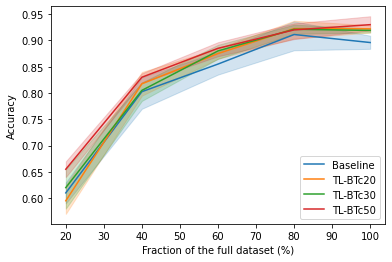

In [11]:
img = sns.lineplot(data=all_df, x="Fraction of the full dataset (%)", y="Accuracy", hue="model")
img.legend(loc='lower right')
figname = "Compare_test_acc_of_reduced_c20icub_rep_new.png"
plt.savefig(logDir+figname, dpi=1200)
figname = "Compare_test_acc_of_reduced_c20icub_rep_new.pdf"
plt.savefig(logDir+figname, dpi=1200)